## Problem Set 4

This problem set will build upon ideas for B-Trees and suffix tries that we have already presented in the videos and notes. The code in the notes will be very important for completing this assignment. We suggest that you familiarize yourself with the notes (interactive labs) before starting this problem set.

## Problem 1 

We will revisit the insertion algorithm for B-Trees in this problem. Recall that the insertion algorithm presented in class was rather simple. If a node is full, we split it into two. If needed, we will insert a new key into the parent. This process goes up the tree and if need be, creates a new root node.


For this problem, we would like to implement the "lending scheme" similar to the "borrowing scheme" that we considered for key deletion in B-Trees for the insertion algorithm. The key idea is that if a node is over-full (has $2d + 1$ keys) as a result of an insertion, we would like to perform the following steps:
  - Check if the node has a right sibling and it has $< 2d$ keys. If so, shift the rightmost key up to the parent node and the key from the parent node as the leftmost key of the right sibling. If the node/right sibling is not a leaf, we need to move pointers as well.
  - Check if the node has a left sibling and it has $< 2d$ keys. If so, shift the leftmost key up to the parent node and the key from the parent node as the rightmost key of the left sibling. If the node/left sibling is not a leaf, we need to move pointers as well.
  - If both of the conditions above do not hold, split the node into two according to the median and insert a parent at the leaf. This is the same procedure as before.
  
 The advantages of doing things this way include: (a) efficiency -- we have insertions potentially finishing faster with a few key exchanges (in a real B-Tree the sibling nodes may be on the disk and that may actually cause insertions to be slower but we will ignore this in our implementation); and (b) balance -- splitting a full node into two causes two nodes that are just half full. By lending keys, we are ensuring that splitting only happens when the node and its sibling are at capacity.

Here is the base object for a `BTreeNode` given to you exactly as we had implemented in the notes. 

In [2]:
class BTreeNodeBase(object):
    def __init__(self, keys = [], ptrs = [], is_root=False, d = 10):
        # each internal node must contain at least d keys and at most 2d  keys
        # The root which may contain between 0 keys (if entire tree is empty) and 2d keys
        self.keys = list(keys) # the keys
        self.d = d # the value of d
        self.pointers = list(ptrs)  # the pointers 
        self.is_root = is_root
        self.parent = None # either None or a tuple (parent_node, idx) such that parent_node.pointers[idx] = self
        
    def is_leaf(self):
        """returns True if the node is a leaf or else returns False"""
        return len(self.pointers) == 0
    
    def set_parent(self, parent_node, idx):
        assert parent_node != None
        assert 0 <= idx and idx < len(parent_node.pointers)
        assert parent_node.pointers[idx] == self
        self.parent = (parent_node, idx)
    
    def find_key_internal(self, k):
        """ find_key_internal for a key k returns reference to node and the index into keys array if found.
            Otherwise, returns None
        """     
        n = len(self.keys)
        if n == 0: # empty node return False 
            return None
        # find first index i such that self.keys[i] >= k
        i = 0
        while i < n and self.keys[i] < k:
            i = i + 1
        if i < n and self.keys[i] == k:
            return (self, i) # we are done: found the key
        else: 
            if  self.is_leaf(): # if we are at a leaf, then key not found
                return None
            else: # otherwise, we recursively search in the appropriate child node
                return self.pointers[i].find_key_internal(k)
            
    def find_key(self, k):
        """find_key function to be called by outsiders at the root node"""
        assert self.is_root
        res = self.find_key_internal(k) # call the find_key_internal method
        return True if res != None else False 
    
    def find_successor(self, idx):
        """find_successor : traverse the node to the right of idx 
            and then keep traversing left children until we get to a leaf"""
        assert idx >= 0 and idx < len(self.keys) # assert that the index is a proper index
        assert not self.is_leaf() # do not call this function on a leaf
        child = self.pointers[idx+1] # get the right child 
        while not child.is_leaf():
            child = child.pointers[0] # go left 
        assert child.is_leaf() # we have gotten to the leftmost leaf
        return (child.keys[0], child)
    
    def __str__(self):
        return str(self.keys)
    
    def make_networkx_graph(self, G, node_id, parent_id, label_dict):
        node_label = str(self.keys)
        if self.parent != None:
            node_label =  "C"+str(self.parent[1]) + ": " + node_label
        else:
            node_label = "R: "+ node_label
        G.add_node(node_id, label=node_label)
        label_dict[node_id] = node_label
        if parent_id >= 0:
            G.add_edge(parent_id, node_id)
        n = len(self.pointers)
        new_id = node_id+1
        for i in range(n):
            new_id = self.pointers[i].make_networkx_graph(G, new_id, node_id, label_dict)
        return new_id + 1
    
    def rep_ok(self):
        """Check if the BTree respects  properties."""
        n = len(self.keys)
        p = len(self.pointers)
        d = self.d
        # node is a leaf with no pointers or it must have one more pointer than the number of keys
        assert p == 0 or p == n + 1, f'Node has {n} keys but {p} pointers'
        # are the keys in ascending order 
        for i in range(1, n):
            assert self.keys[i] > self.keys[i-1], f'Keys {keys[i-1]} and {keys[i]} fail to be in ascending order' 
        if self.is_root:
            assert self.parent == None # root has no parent
            assert 0 <= n and n <= 2 * d  # number of keys for root must be within [0, 2d]
            self.check_height_properties() # check that the length of all paths from root to leaf are the same
        else:
            assert self.parent != None # non root must have a parent
            assert d <= n and n <= 2 * d  # number of keys must be within [d, 2d]
        if p >= 1:
            for (j, child_node) in enumerate(self.pointers): # for each child node
                assert child_node.parent == (self, j) # is the parent pointer of the child node correct?
                assert child_node.d == self.d
                assert not child_node.is_root
                child_node.rep_ok() # check if the child node itself respect properties recursively
    
    def check_height_properties(self):
        """Check that the height of all child nodes are the same and return height of self"""
        if self.is_leaf():
            return 0
        else:
            depths= [child.check_height_properties() for child in self.pointers]
            d0 = depths[0]
            assert all(di == d0 for di in depths), f'Node with keys {self.keys} has mismatched depths'
            return 1 + d0
        
    def create_new_instance(self, keys, ptrs, is_root, d):
        """We need this to construct a new instance because we chose to split the implementation across three different classes"""
        return BTreeNodeBase(keys, ptrs, is_root, d)

We would like you to modify the `BTreeNodeWithInsert` class below that implements the insert function. For your convenience, we have modified it so that when a node becomes full, it calls the `handle_full_node` function. This function should 
  - (a) check if the node has a right sibling and whether it can "lend" a key to the right sibling. If so, it should implement that and remember to update the pointers. The function `fix_pointers_for_children` will be very useful.
  - (b) check if the node has a left sibling and whether it can "lend" a key to the right sibling. If so, it should implement that and remember to update the pointers. The function `fix_pointers_for_children` will be very useful.
  - (c) Otherwise, we revert back to the old code for splitting a node that is given to you.
  
 Complete the implementation of the `handle_full_node` function below. Note that it is being called at two places from the `insert_helper` function. 

[1]
print out  1


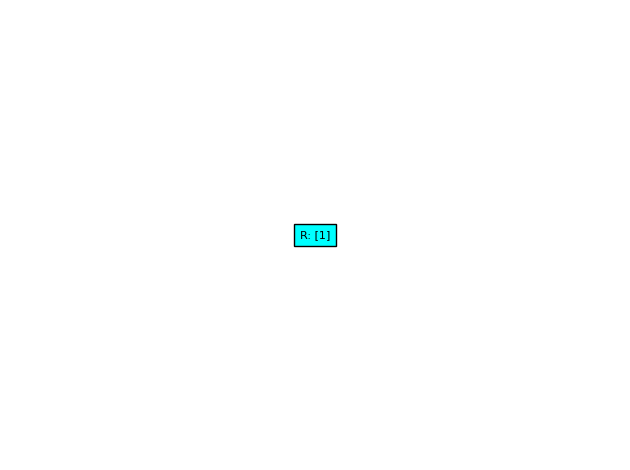

[1, 5]
print out  5


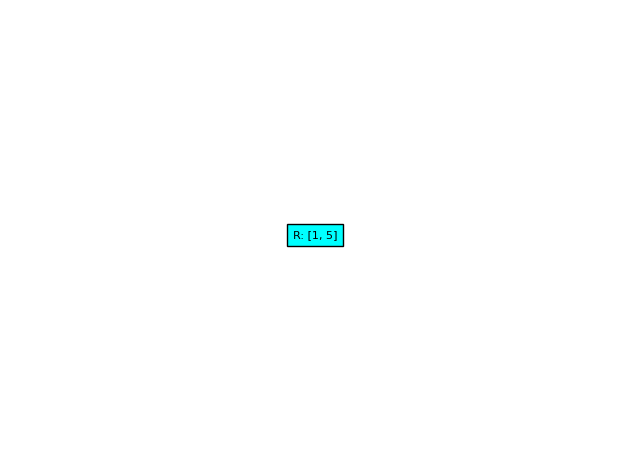

[1, 5, 2]
1
3
d is  1
3 0
print out  2


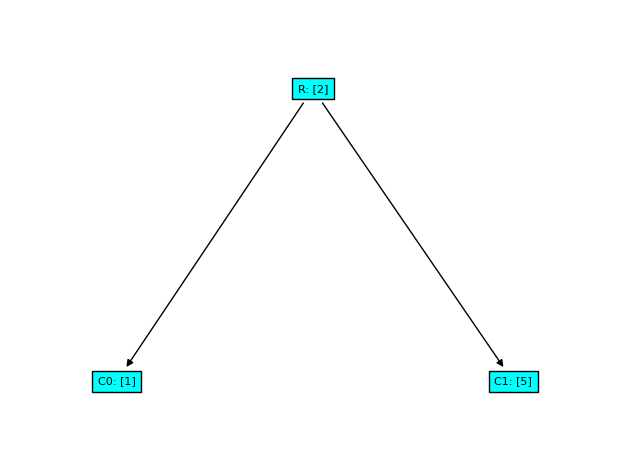

[5, 4]
print out  4


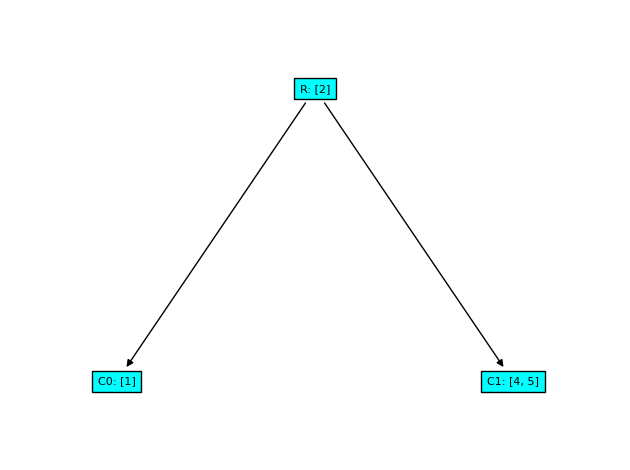

[4, 5, 3]
1
3
d is  1
[3, 4, 5]
[1, 2]
print out  3


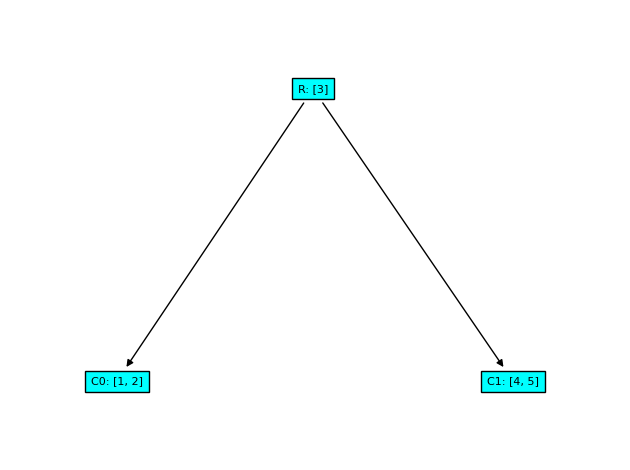

[4, 5, 9]
1
3
d is  1
[4, 5, 9]
3 0
[4] [3, 5]
print out  9


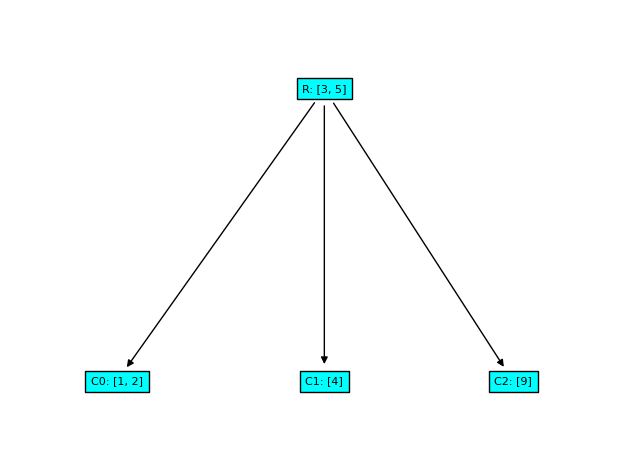

[9, 15]
print out  15


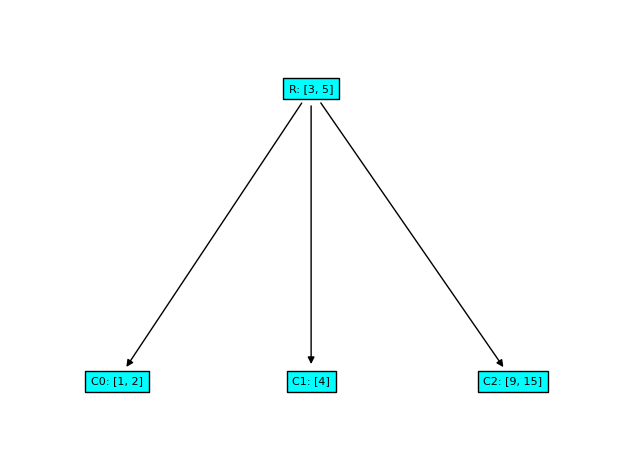

[1, 2, -5]
1
3
d is  1
[-5, 1, 2]
[4, 3]
print out  -5


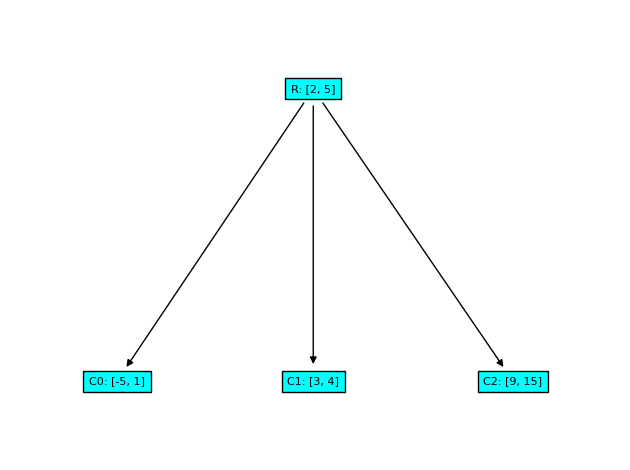

[9, 15, 12]
1
3
d is  1
[9, 12, 15]
3 0
[9] [2, 5, 12]
d is now 1 mid l keys r keys 5 [2] [12]
print out  12


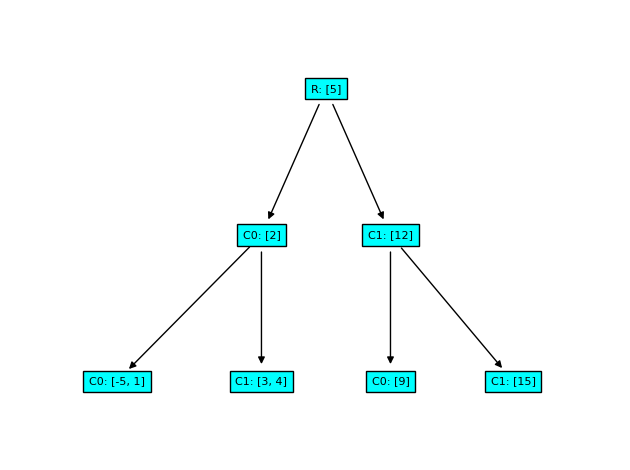

[15, 18]
print out  18


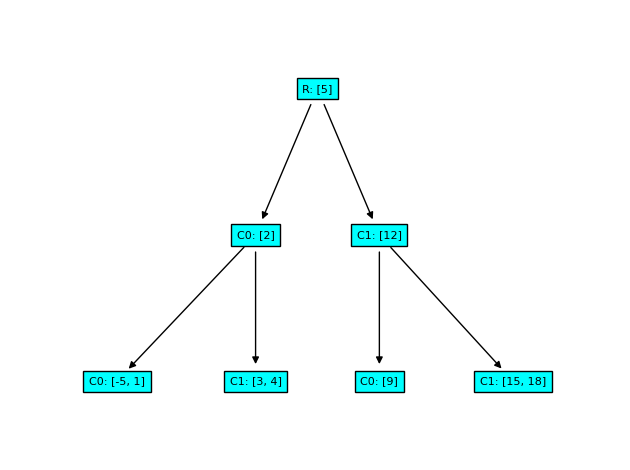

[15, 18, 80]
1
3
d is  1
[15, 18, 80]
[9, 12]
print out  80


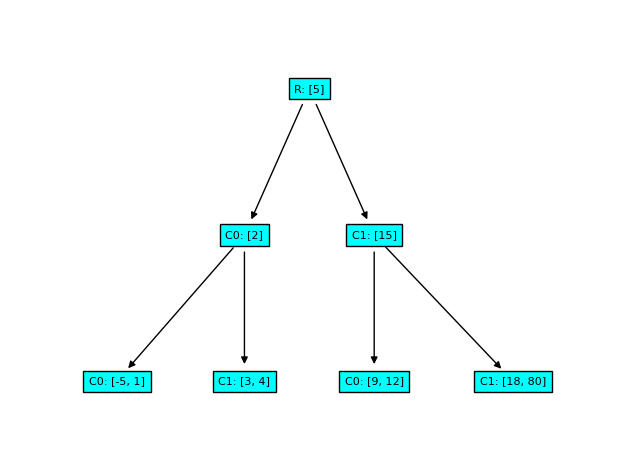

[-5, 1, -25]
1
3
d is  1
[-25, -5, 1]
3 0
[-25] [-5, 2]
print out  -25


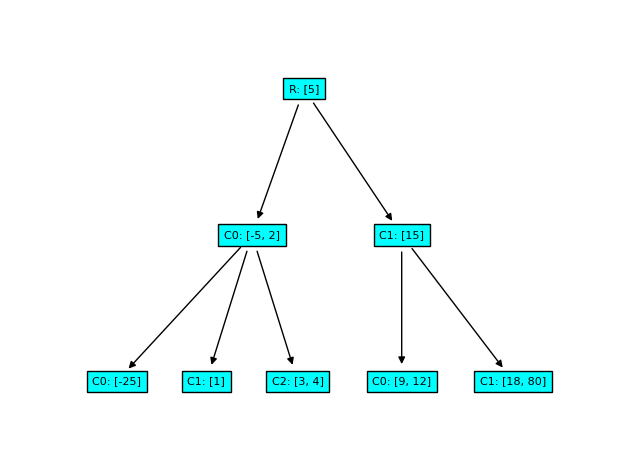

[18, 80, 22]
1
3
d is  1
[18, 22, 80]
3 0
[18] [15, 22]
print out  22


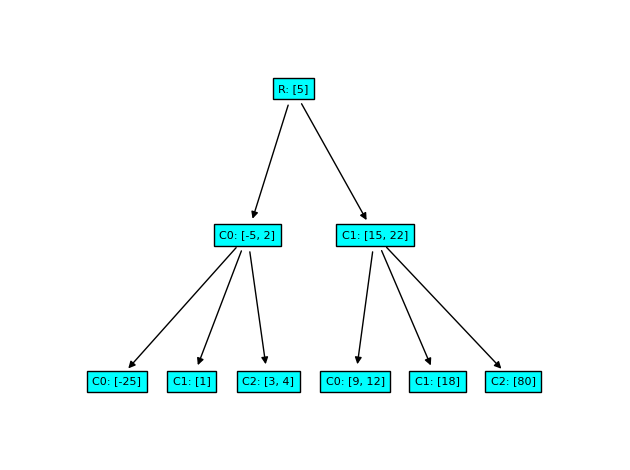

[80, 31]
print out  31


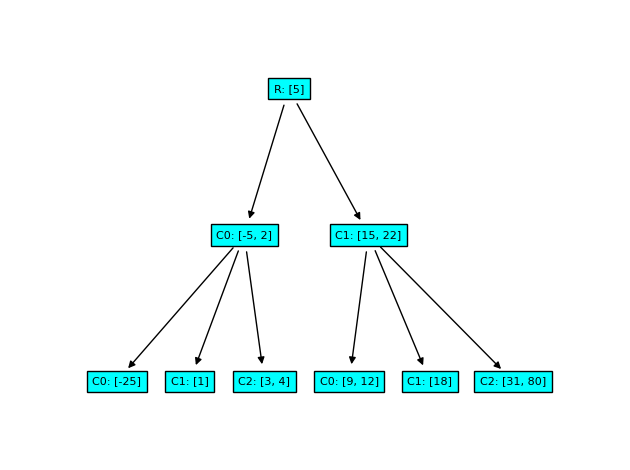

[-25, -15]
print out  -15


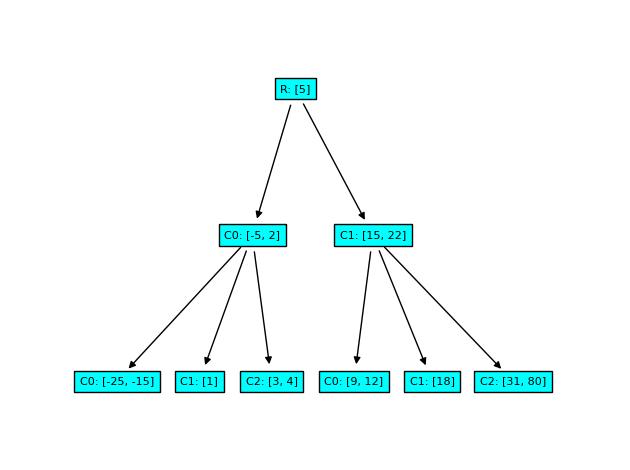

[9, 12, 14]
1
3
d is  1
[9, 12, 14]
[18, 15]
print out  14


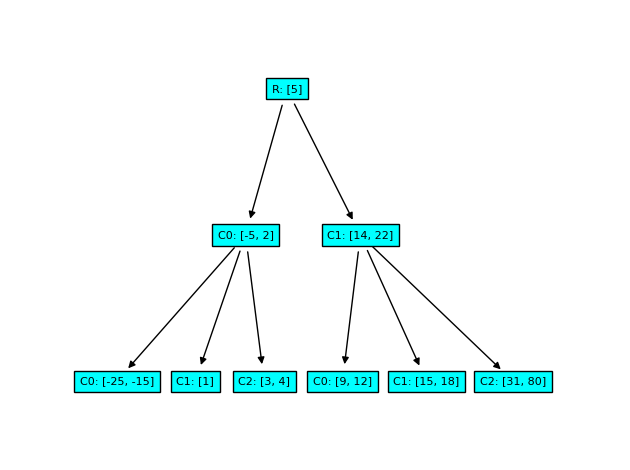

[15, 18, 21]
1
3
d is  1
[15, 18, 21]
3 0
[15] [14, 18, 22]
3 4
print out  21


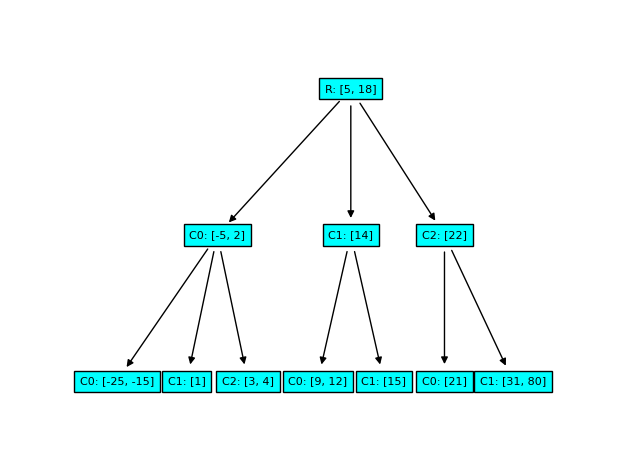

[-25, -15, -24]
1
3
d is  1
[-25, -24, -15]
[1, -5]
print out  -24


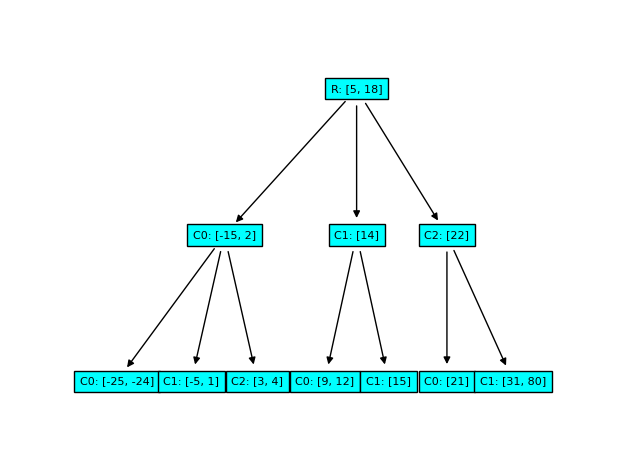

[21, 19]
print out  19


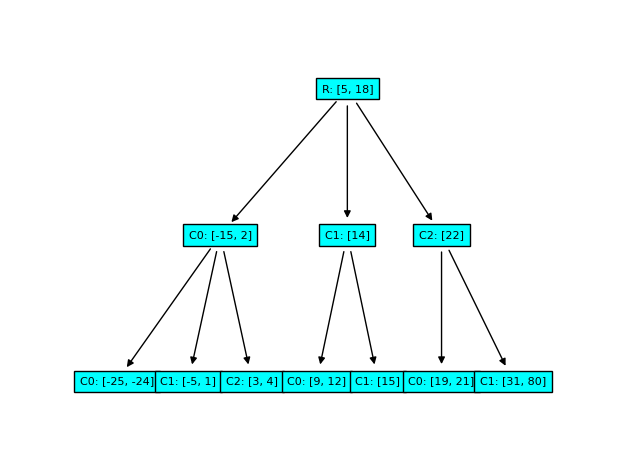

[5, 18]


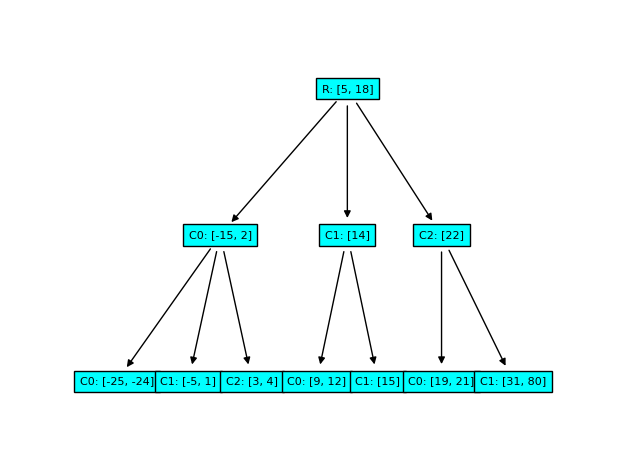

[-25, -24, -15, -5, 1, 2, 3, 4, 5, 9, 12, 14, 15, 18, 19, 21, 22, 31, 80]


In [14]:
import copy
class BTreeNodeWithInsert(BTreeNodeBase):
    
    def __init__(self, keys = [], ptrs = [], is_root=False, d = 10):
        super().__init__(keys, ptrs, is_root, d)
        
    def create_new_instance(self, keys, ptrs, is_root, d):
        """We need this to construct a new instance because we chose to split the implementation across three different classes"""
        return BTreeNodeWithInsert(keys, ptrs, is_root, d)
    
        
    def insert(self, new_key):
        """Insert a key new_key into the tree. 
           Call this only when self is the root node"""
        #self.d=self.get_depth() i had a misunderstanding.... d should be just 1
        assert self.is_root
        #if new_key==19:
        #    self.keys=[-5,22]
        #    self.pointers=[self.pointers[0]]+[self.pointers[1]]+[self.pointers[-1]]
        res = self.insert_helper(new_key) # the helper function has the logic for insertion
        if res != None: 
            (mid_key, n1, n2) = res # if the helper function returns a triple mid_key and two new nodes
            self.is_root = False  # we need to create a new root
            new_root = self.create_new_instance( [mid_key], [n1, n2], True, self.d) # create new root with a single key and two children
            n1.set_parent(new_root, 0) # set the parent pointers for n1, n2
            n2.set_parent(new_root, 1)
            return new_root  # return the new_root
        else:
            return self # Otherwise, the root node is unchanged
    
    def insert_helper(self, new_key, debug=True):
        """ This is a helper function for inserting a new key new_key into a node. 
        It returns either None which means that there was space for the key 
        or a triple (mid_key, n1, n2) to be inserted up into the parent node."""
        # if the node is a leaf
        if self.is_leaf(): 
            self.insert_key_into_list(new_key) # insert the key into the list
            n = len(self.keys)  # count the number of keys
            #correction??
            #self.d=self.get_depth()
            if n <= 2* self.d:  # node size is acceptable
                return None       # we are done, return None
            else:
                # node is full, we need to split 
                #assert n == 2 * self.d + 1 # Node just became full as a result of this new insertion
                #(mid_key, n1, n2) = self.split_node_into_two() # split it into two nodes
                #return (mid_key, n1,  n2) # return the two nodes and middle key
                print(self.d)
                print(n)
                return self.handle_full_node()
        else:
            # find first index i such that self.keys[i] >= k
            i = 0
            n = len(self.keys)
            while i < n and self.keys[i] < new_key:
                i = i + 1
            # We should not find a copy of the key 
            if  i < n and self.keys[i] == new_key:
                if debug:
                    print(f'Key {k} already exists') # this is bad but ignore for now
                return None           
            else:
                res = self.pointers[i].insert_helper(new_key) # insert into the child
                if res != None:
                    (mid_key, node_left, node_right) = res # unpack
                    # insert the new key coming up from the child into self along with the two pointers
                    self.insert_key_and_ptr(mid_key, node_left, node_right, i)
                    # did the node become full as a result of the insertion?
                    if len(self.keys) >= 2 * self.d+1:
                        return self.handle_full_node()
                        #(mid_key, n1, n2) = self.split_node_into_two() # split myself into two
                        #return (mid_key, n1, n2) # return the median key and two nodes back to my caller
                 
            
    def insert_key_into_list(self, new_key):
        """Insert new_key into the list for this node. Call this function only on leaf nodes"""
        assert self.is_leaf()
        n = len(self.keys)
        assert new_key not in self.keys, f'key {new_key} already exists {self.keys}'
        self.keys.append(new_key)
        print(self.keys)
        i = n
        while i >= 1 and self.keys[i] < self.keys[i-1]:
            # swap
            (self.keys[i-1], self.keys[i]) =  (self.keys[i], self.keys[i-1])
            i = i-1
            
    def insert_key_and_ptr(self, mid_key, node_left, node_right, i):
        """Insert the new_key into the list at position i. 
           Make sure that its left child is 
           node_left and right child is node_right. """
        n = len(self.keys)
        assert i >= 0 and i <= n
        #node_left.set_parent(self, i)
        node_left.parent=(self, i)#changed 
        #assert self.keys[i] > mid_key
        assert self.pointers[i] == node_left 
        (new_key, new_child) = (mid_key, node_right)
        for j in range(i, n):
            (self.keys[j], new_key) = (new_key, self.keys[j])
            (self.pointers[j+1], new_child) = (new_child, self.pointers[j+1])
            self.pointers[j+1].set_parent(self, j+1) # fix the parent pointer since the child node position changes
        self.keys.append(new_key)
        self.pointers.append(new_child)
        new_child.set_parent(self, n+1)
        
    def fix_parent_pointers_for_children(self):
        for (j, child_node) in enumerate(self.pointers):
            child_node.set_parent(self, j)
        
    def split_node_into_two(self):
        #print(self.keys)
        #print(self.d)
        """Split a node into two along the median. Call only if the node is full"""
        print(len(self.keys),len(self.pointers) )
        assert len(self.keys) == 2 * self.d + 1 or len(self.pointers) == 2 * self.d + 1 # node is full or the children are full
        n = len(self.keys)
        d = self.d
        med_key = self.keys[d]
        new_keys = list(self.keys[d+1:]) # take all keys past position d + 1
        self.keys = list(self.keys[:d])
        if self.is_leaf():
            new_ptrs = []
        else:
            new_ptrs = list(self.pointers[d+1:])
            self.pointers = list(self.pointers[:d+1])# new parents???
        #print("checking new nodes")
        #print(new_keys)
        new_node = self.create_new_instance(new_keys, new_ptrs, False, d) # create a new node 
        new_node.fix_parent_pointers_for_children() # make sure that for the new node, we fix the parent pointers for children to now point to the new node 
        #print(new_node)
        #code i added
        #self.d+=1
        #if the parent node is full!
        
        
        return (med_key, self, new_node) ## return a triple of things to insert
    
    def get_depth(self):#stupid algorithm just to solve a trouble
        #find root
        p=[]
        for i in range(100): # i suppose that you do not have a tree that has more than 100 levels
            if len(p)==0:
                p.append(self)
            elif not p[-1].is_root:
                p.append(p[-1].parent[0])
            else:
                break
        child0=[]
        for i in range(100):
            if len(child0)==0:
                child0.append(self)
            else:
                if len(child0[-1].pointers)==0:
                    return len(p)+len(child0)-1
                else:
                    child0.append(child0[-1].pointers[0])
        return None #Failure

        
    
    def handle_full_node(self, debug=True):
        """Try to lend a key to left or right sibling if they have < 2*self.d keys.
           Otherwise, split the node into two.
        
        Return value:
        
            If we can successfully lend the key/pointer to either sibling, return None
            Otherwise, return whatever result self.split_node_into_two() does.
        """
        # use debug key to print useful messages for your debugging
        #print(self.keys)
        #print(self.d)
        print("d is ",self.d)
        assert len(self.keys) == 2 * self.d + 1
        d = self.d
        if self.parent == None : # already at the root
            return self.split_node_into_two() # no other option but to split
        # unpack the parent pointer
        (parent_node, parent_idx) = self.parent
        # self is the child of parent_node and equals parent_node.pointers[parent_idx]
        ## TODO:
        ##   1. Check if I have a right sibling node, fetch right sibling node and find out if it has space.
        ##        1.1. If right sibling exists and has space, lend my rightmost key and pointer to the right sibling as its leftmost key and pointer
        ##        1.2 Do not forget to call the function fix_parent_pointers since parent pointers will get invalidated.
        ##        1.2 Insertion is done, return None
        ##   2. Check if I have a left sibling node, fetch left sibling node and find out if it has space
        ##        2.1 If left sibling exists and has space, lend my leftmost key and pointer to left sibling as its rightmost key and pointer 
        ##        3.3 Insertion is done, return None
        ##   3. If neither options work, return self.split_node_into_two() -- already implemented see above.
        ##  Look at the deletion code for B-Tree given in the notes first since it uses a similar (but not the same) strategy.
        
        # your code here
        # step 1 check right sibling
        keys=self.keys
        left=keys[0]
        right=keys[len(keys)-1]
        (p,idx)=self.parent #(parent_node, idx) 
        p_pointers=p.pointers
        p_max=len(p_pointers)
        p_keys=p.keys
        len_r=2*d
        len_l=2*d
        if idx<p_max-1:
            r_sib=p_pointers[idx+1]
            r_sib_keys=r_sib.keys
            len_r=len(r_sib.keys)
        if idx>0:
            l_sib=p_pointers[idx-1]
            l_sib_keys=l_sib.keys
            len_l=len(l_sib.keys)    
        print(self.keys)
        if idx<p_max-1 and len_r<2*d :
            
            
            #print("case1")
            
            p_r=p_keys[idx]
            if len(r_sib_keys)<2*d:
                p_keys[idx]=right
                r_sib.insert_helper(p_r, debug=True)
                r_sib.fix_parent_pointers_for_children()
                #delete the key!
                self.keys=self.keys[0:len(keys)-1]
                #compare parent's keys vs the inserted key
                
        elif idx>0 and len_l<2*d:
            #print("case2")
            
            p_l=p_keys[idx-1]
            if len(l_sib_keys)<2*d:
                p_keys[idx-1]=left
                l_sib.insert_helper(p_l, debug=True)
                l_sib.fix_parent_pointers_for_children()
                self.keys=self.keys[1:len(keys)]
        else:
            #print("case3")
            (med_key, self, new_node)=self.split_node_into_two()# it returns (med_key, self, new_node)
            #we need to add the median to the parent
            self.parent[0].insert_key_and_ptr(med_key,self,new_node,idx) #mid_key, node_left, node_right, i
            print(self.keys,self.parent[0].keys)
            #print(d)
            #if parent node is full!
            if len(self.parent[0].pointers)==2*self.parent[0].d+2:
                if self.parent[0].parent==None:
                    n = len(self.keys)
                    med_key = self.parent[0].keys[d]
                    r_keys = list(self.parent[0].keys[d+1:]) # take all keys past position d + 1
                    l_keys = list(self.parent[0].keys[:d])
                    r_ptrs = list(self.parent[0].pointers[d+1:])
                    l_ptrs = list(self.parent[0].pointers[:d+1])# new parents???
                    self.parent[0].keys=[med_key]#+[10000]
                    print("d is now",d,"mid l keys r keys",med_key,l_keys,r_keys)
                    l_node = self.parent[0].create_new_instance(l_keys, l_ptrs, False, d) # create a new node 
                    r_node = self.parent[0].create_new_instance(r_keys, r_ptrs, False, d) # create a new node 
                    self.parent[0].pointers=[l_node,r_node]
                    self.parent[0].fix_parent_pointers_for_children()
                    l_node.fix_parent_pointers_for_children()
                    r_node.fix_parent_pointers_for_children()
                else:
                    (med_key, new_parent, new_node)=self.parent[0].split_node_into_two()# it returns (med_key, self, new_node)
                    self.parent=(new_parent,self.parent[1])
                    self.parent[0].parent[0].insert_key_and_ptr(med_key,self.parent[0],new_node,self.parent[1]) 
   
                
                
                #self.parent[0].insert_key_and_ptr(med_key,self,new_node,idx) #mid_key, node_left, node_right, i

                
lst = [1, 5, 2, 4, 3, 9, 15, -5, 12, 18, 80, -25, 22, 31, -15, 14,  21, -24, 19]
b = BTreeNodeWithInsert(d=1,is_root=True)
for k in lst:
    b = b.insert(k)
    print(f'print out ',k)
    if b.parent!=None:
        print(b.parent[0].keys)
    #if k==21:
    draw_btree_graph(b)
print(b.keys)
draw_btree_graph(b)
b.rep_ok()

print(sorted(lst))
for i in lst:
    assert b.find_key(i), f'Key {i} not found in the tree though it was inserted'
assert len(b.keys) == 2, f'Root must have 2 keys. Yours has {len(b.keys)} keys'  

In [11]:
%matplotlib inline
import networkx as nx 
from matplotlib import pyplot as plt 

def draw_btree_graph(n):
    G = nx.DiGraph()
    labels = {}
    n.make_networkx_graph(G, 0, -1, labels)
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # positions for all nodes
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    nx.draw(G, pos=pos, with_labels=True,  node_shape="s", font_size=8, labels=labels, node_color="none",  bbox=dict(facecolor="cyan", edgecolor='black'))
    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()

[1]
[1, 5]
[1, 5, 2]
[1, 2, 5, 4]
[1, 2, 4, 5, -4]
2
5
d is  2
5 0
[-4, 1, -3]
[-4, -3, 1, -7]
[4, 5, 12]
Starting tree is : 


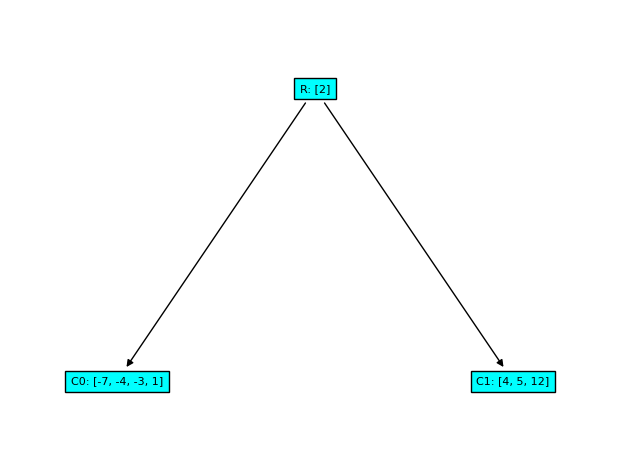

Inserting -8
[-7, -4, -3, 1, -8]
2
5
d is  2
[-8, -7, -4, -3, 1]
[4, 5, 12, 2]


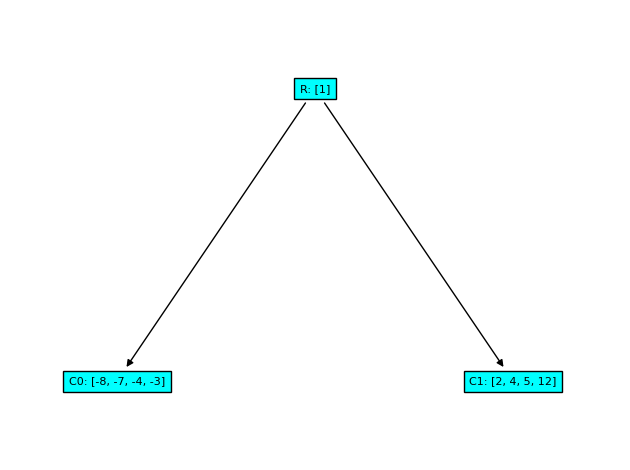

In [12]:
# Do not forget to run the cell implementing `draw_btree_graph` function above. 
# it will be very useful to visualize
lst = [1, 5, 2, 4, -4, -3, -7, 12]
b = BTreeNodeWithInsert(d=2,is_root=True)
for k in lst:
    b = b.insert(k)
b.rep_ok()
print('Starting tree is : ')
draw_btree_graph(b)

## Note: the insertions above will not trigger any calls to the student's code unless student has modified instructor's code
# TEST lending key to right sibling
print('Inserting -8')
b = b.insert(-8)
b.rep_ok()

draw_btree_graph(b)

assert len(b.keys) == 1, f'root must have just one key. Your root has {len(b.keys)}'
assert b.keys[0] == 1, f'root must have a single key : [1]. Your root has {b.keys}'
c0 = b.pointers[0]
c1 = b.pointers[1]
assert c0.is_leaf()
assert c1.is_leaf()
assert c0.keys == [-8,-7, -4, -3], f'Left child of root must have keys [-8, -7, -4, -3]. Your left child has keys {c0.keys}'
assert c1.keys == [2,4,5, 12], f'Right child of root must have keys [2,4,5, 12]. Your right child has keys {c1.keys}'



[1]
[1, 5]
[1, 5, 2]
[1, 2, 5, 4]
[1, 2, 4, 5, -4]
2
5
d is  2
5 0
[4, 5, 3]
[3, 4, 5, 7]
Starting tree is : 


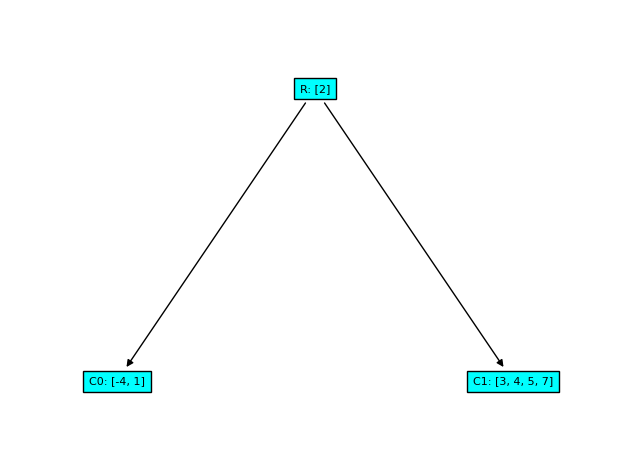

Inserting 8
[3, 4, 5, 7, 8]
2
5
d is  2
[3, 4, 5, 7, 8]
[-4, 1, 2]


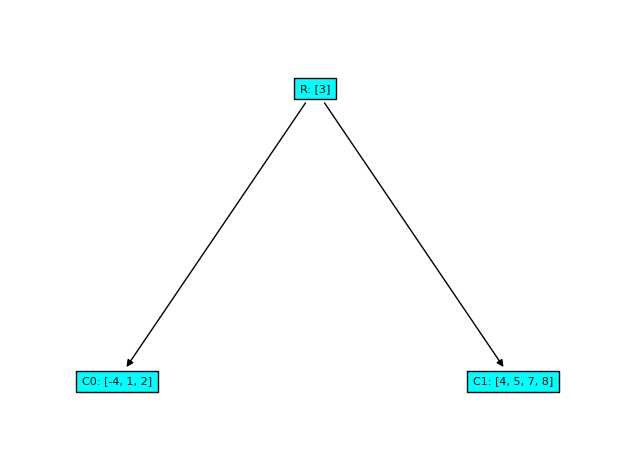

Inserting 6
[4, 5, 7, 8, 6]
2
5
d is  2
[4, 5, 6, 7, 8]
[-4, 1, 2, 3]


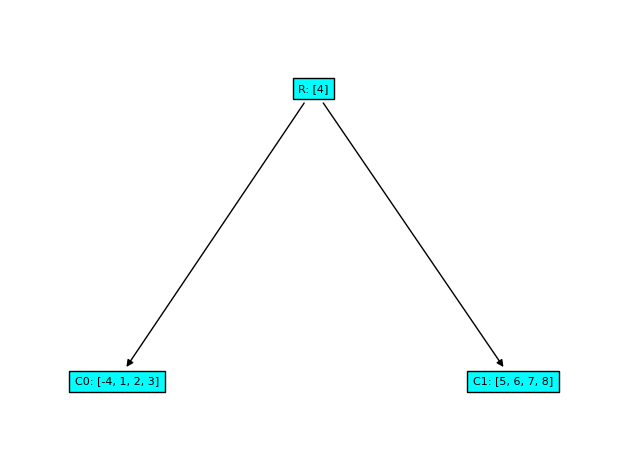

In [13]:
# Do not forget to run the cell implementing `draw_btree_graph` function above. 
# it will be very useful to visualize
lst = [1, 5, 2, 4, -4, 3, 7]
b = BTreeNodeWithInsert(d=2,is_root=True)
for k in lst:
    b = b.insert(k)
b.rep_ok()
print('Starting tree is : ')
draw_btree_graph(b)
## Note: the insertions above will not trigger any calls to the student's code unless student has modified instructor's code
print('Inserting 8')
b = b.insert(8)
b.rep_ok()

draw_btree_graph(b)
# this should call the routine where we lend to left sibling
# check the following
# btree must have three nodes
# root must have a single key [3]
# left child of root must have 3 keys [-4, 1, 2]
# right child of root must have 4 keys [4, 5, 7, 8]

assert len(b.keys) == 1
assert b.keys[0] == 3, f'root must have a single key : 3. Your root has {b.keys}'
c0 = b.pointers[0]
c1 = b.pointers[1]
assert c0.is_leaf()
assert c1.is_leaf()
assert c0.keys == [-4, 1, 2], f'Left child of root must have keys [-4, 1, 2]. Your left child has keys {c0.keys}'
assert c1.keys == [4, 5, 7, 8], f'Right child of root must have keys [4, 5, 7, 8]. Your right child has keys {c1.keys}'

print('Inserting 6')
b = b.insert(6)
b.rep_ok()
draw_btree_graph(b)


assert len(b.keys) == 1
assert b.keys[0] == 4, f'root must have a single key : 4. Your root has {b.keys}'
c0 = b.pointers[0]
c1 = b.pointers[1]
assert c0.is_leaf()
assert c1.is_leaf()
assert c0.keys == [-4, 1, 2, 3], f'Left child of root must have keys [-4, 1, 2,3]. Your left child has keys {c0.keys}'
assert c1.keys == [5,6, 7, 8], f'Right child of root must have keys [5, 6, 7, 8]. Your right child has keys {c1.keys}'


[1]
[1, 5]
[1, 5, 2]
1
3
d is  1
3 0
[5, 4]
[4, 5, 3]
1
3
d is  1
[3, 4, 5]
[1, 2]
[4, 5, 9]
1
3
d is  1
[4, 5, 9]
3 0
[4] [3, 5]
[9, 15]
[1, 2, -5]
1
3
d is  1
[-5, 1, 2]
[4, 3]
[9, 15, 12]
1
3
d is  1
[9, 12, 15]
3 0
[9] [2, 5, 12]
d is now 1 mid l keys r keys 5 [2] [12]
[15, 18]
[15, 18, 80]
1
3
d is  1
[15, 18, 80]
[9, 12]
[-5, 1, -25]
1
3
d is  1
[-25, -5, 1]
3 0
[-25] [-5, 2]
[18, 80, 22]
1
3
d is  1
[18, 22, 80]
3 0
[18] [15, 22]
[80, 31]
[-25, -15]
[9, 12, 14]
1
3
d is  1
[9, 12, 14]
[18, 15]
[15, 18, 21]
1
3
d is  1
[15, 18, 21]
3 0
[15] [14, 18, 22]
3 4
[-25, -15, -24]
1
3
d is  1
[-25, -24, -15]
[1, -5]
[21, 19]


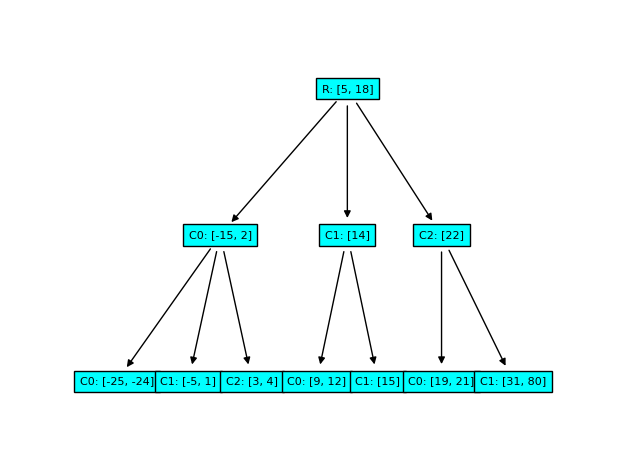

[-25, -24, -15, -5, 1, 2, 3, 4, 5, 9, 12, 14, 15, 18, 19, 21, 22, 31, 80]


In [15]:
# Do not forget to run the cell implementing `draw_btree_graph` function above. 
# it will be very useful to visualize
lst = [1, 5, 2, 4, 3, 9, 15, -5, 12, 18, 80, -25, 22, 31, -15, 14,  21, -24, 19]
b = BTreeNodeWithInsert(d=1,is_root=True)
for k in lst:
    b = b.insert(k)
b.rep_ok()
draw_btree_graph(b)
print(sorted(lst))
for i in lst:
    assert b.find_key(i), f'Key {i} not found in the tree though it was inserted'
assert len(b.keys) == 2, f'Root must have 2 keys. Yours has {len(b.keys)} keys'

## Problem 2 

The inefficient algorithm for suffix trie that we presented in our notes did not construct suffix links. We noted that suffix links are very important for algorithms such as finding the longest common substrings between two strings.
$$\newcommand\suff{\mathsf{suff}}$$
Let $s$ be a string of length $n$ and suppose we have found its suffix trie with root $r$. However, the trie has no suffix links.

Recall the notion of suffix links:
 - Every internal node $n$ of the trie has a unique path from the root to $n$ which is labeled with a non-empty substring of $s$.
 - Suppose an internal node $n$'s path from root corresponds to a substring of the form $c \alpha$ where $c$ is a character and $\alpha$ is an arbitrary length substring, then the suffix node $\suff(n)$ is either the root or an internal node whose unique path from root is labeled by $\alpha$.

A suffix link is a link from each internal node (and root) to its suffix node $\suff(n)$.  For convenience, $\suff(r) = r$.

In this problem, we ask you to find an efficient algorithm for constructing suffix links in a suffix trie without them. The idea is to construct suffix links for internal nodes in a depthwise fashion. 
 - The suffix link for the root is itself.
 - Suppose for a node $n$, the suffix link for its parent node $p$ is known to be $\suff(p)$, we would like you to work out the suffix link for $n$ knowing $\suff(p)$ and the sub-string along the edge $n \rightarrow p$.
 
In this manner, we can compute a depth first traversal of the tree and having computed the suffix link for the parent of a node, we can figure out the suffix link for the node itself.

First, we will ask you to work out the algorithm step by step and next, we will implement it.

### Case-1: Parent is the root

Suppose the node $n$'s parent $p$ is the root node of the trie ($p =r$), and the edge 
$r \rightarrow n$ corresponds to the substring: $s[lo], \ldots, s[hi]$. 

__(A)__ Write down the substring that would correspond to the unique path from the root  to the suffix node of $n$.


 

YOUR ANSWER HERE

### Case -2 : Parent is not the root.

Suppose $n$'s parent $p$ is an internal node (not the root) and the edge 
$p \rightarrow n$ corresponds to the substring: $s[lo], \ldots, s[hi]$. 

Let $s(p)$ be the suffix link for the parent node. Let $s(n)$ be the node that would correspond to the target of the suffix link from $n$ if it existed.

__(B)__ What would be the substring that would lead us from $s(p)$ to $s(n)$? 


YOUR ANSWER HERE

__(C)__ We will use the insights above to  down all the missing suffix links for the given trie.

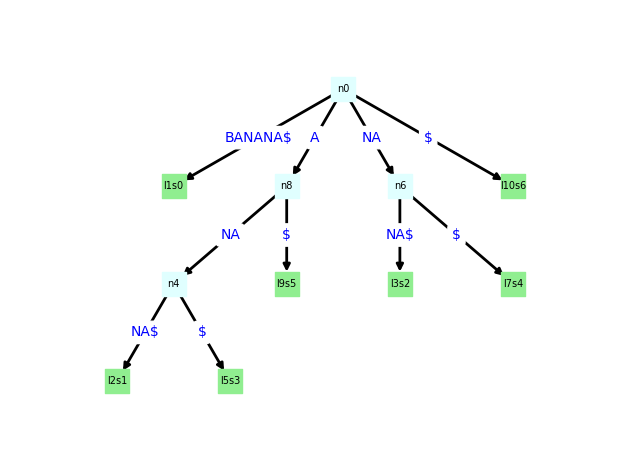</img>

Knowing that the root is suffix linked to itself. Consider node $n8$. It's parent is the root $n0$ and the edge from $n0 \rightarrow n8$ has $lo = hi = 1$ the "A" character in "BANANA$".

What should the suffix link for $n8$ be?

YOUR ANSWER HERE

__(D)__ Compute the target node for the suffix link for $n4$, given your answer from the previous step.

YOUR ANSWER HERE

We have given you the data structure for suffix trie and the code for constructing it in $O(m^2)$ time but without suffix links. Please ensure that the cell below is run before proceeding.

This includes classes `SuffixTrieNode`, `SuffixTrieEdge`, `SuffixTrieLeaf` and `TrieAddress` directly taken from the notes.

Finally, we have also included the function `make_suffix_trie` that given a string $s$ constructs a suffix trie for it in $O(|s|^2)$.

In [182]:
class SuffixTrieNode:
    
    def __init__(self, node_id, orig_str):
        self.orig_str = orig_str # a reference to the entire string
        self.outgoing_edges = {} # dictionary from chars to edges
        self.suffix_link = None  # suffix link : initially set to None
        self.id = node_id # Note: id == 0 is taken to be root for now.
        self.depth = 0 # automatically set the depth when node's parent is set
        self.parent = None # parent pointer
        
    def is_root(self):
        return self.id == 0
        
    def get_edge(self, char):
        if char in self.outgoing_edges:
            return self.outgoing_edges[char]
        else:
            return None
        
    def is_leaf(self):
        return False
    
    def add_suffix_link(self, node):
        self.suffix_link = node
        
    def add_outgoing_edge(self, new_edge):
        edge_init_char = new_edge.get_char_at(0)
        # ensure that an edge with the initial character does not exist
        assert edge_init_char not in self.outgoing_edges, f"Char {edge_init_char} already has an outgoing edge for node id:{self.id}"
        #ensure that the new_edge src matches self
        assert new_edge.src.id == self.id, f"Src node in outgoing edge id:{new_edge.src.id} does not match node id {self.id}"
        # add the new edge to the dictionary with the initial char as key
        self.outgoing_edges[edge_init_char] = new_edge
        # add a parent pointer from destination to the src of the new edge
        new_edge.dest.parent = new_edge.src # set the parent pointer of the new edges dest
        if not new_edge.is_leaf_edge(): # set the depth of the destination node for the edge
            new_edge.dest.depth = self.depth + new_edge.length()
       
        
    def find_edge_corresponding_to_child(self, child_node):
        # search among outgoing edges to see if there is one whose destination is the child node
        for (_, edge) in self.outgoing_edges.items():
            if edge.dest.id == child_node.id:
                return edge
        return None # no such edge found
    
        
    
class SuffixTrieLeaf:
    def __init__(self, node_id, orig_str, suffix_start_pos):
        self.orig_str = orig_str # the original string
        self.id  = node_id # the id of this node
        assert 0 <= suffix_start_pos < len(orig_str) 
        self.suffix_start_pos = suffix_start_pos # the starting pos for the suffix
        self.parent = None # parent pointer initially set to None
        
    def is_leaf(self):
        return True
    

class SuffixTrieEdge:
    
    def __init__(self, orig_str, src_node, dest_node, lo, hi):
        assert 0 <= lo < len(orig_str) # lo must be a valid position in the original string
        # if destination node is a leaf then hi == -1 else hi != -1
        if dest_node.is_leaf():
            assert hi == -1 
        else:
            assert lo <= hi <= len(orig_str)
        assert not src_node.is_leaf() # src node cannot be a leaf.
        # edge represents str[lo]...str[hi] inclusive if hi != -1
        # or set[lo] ... str[end]
        self.orig_str = orig_str # set the orig_str field
        self.lo = lo # set lo/hi
        self.hi = hi 
        self.src = src_node # set src/dest
        self.dest = dest_node
        
    def is_leaf_edge(self):
        return self.hi == -1
    
    def length(self):
        if self.hi == -1:
            return -1
        else:
            return self.hi - self.lo + 1
    
    def get_char_at(self, offs):
        assert self.hi == -1 or offs + self.lo <= self.hi
        return self.orig_str[self.lo + offs]
    
    
    def get_sub_str(self, end=-1):
        if self.hi == -1:
            return self.orig_str[self.lo:end] if (end != -1) else self.orig_str[self.lo:]
        
        else:
            return self.orig_str[self.lo:self.hi+1]
        
        
    def reset_hi_and_dest(self, new_dest, new_hi):
        assert new_hi >= self.lo, f"Cannot replace hi value by {new_hi}"
        assert not new_dest.is_leaf(), "Cannot replace destination by a leaf node"
        self.hi = new_hi
        new_dest.parent = self.src
        new_dest.depth = self.src.depth + self.length()
        self.dest = new_dest

class TrieAddress:
    
    def __init__(self,  node, edge=None, offs=0):
        assert 0 <= offs 
        self.node = node # set the node
        self.edge = edge # set the edge
        self.offs = offs # set the offset
        if self.edge != None:
            assert self.offs > 0
        else:
            assert self.offs == 0
    
    def traverse_next(self, c):
        """Function traverse_next: find the next address (if one exists) that 
           is obtained when we encounter character c. Return the new address if 
           one exists or else return None."""
        if self.edge == None: # Is the address pointing to an internal node?
            # Yes: address is just a pointer to an internal node/root.
            # check if the node has an outgoing edge corresponding to 'c'
            new_edge = self.node.get_edge(c) # try to get a new edge corresponding to character `c`.
            if new_edge == None:
                return None # No such edge, then return None
            else: # new_edge != None
                assert new_edge.get_char_at(0) == c # got an edge. Check that we got the right one.
                if new_edge.is_leaf_edge() or new_edge.length() > 1: # if new edge is a leaf edge, or its length is more than 2
                    return TrieAddress( self.node, new_edge,  1 ) # return an address with an offset of 1 into the new edge
                else:
                    new_node = new_edge.dest # new edge is not a leaf and must have length exactly one
                    return TrieAddress( new_node, None, 0) # the address must therefore be the destination.
        else: # self.edge != None
            # No: address is a pointer self.offs past self.node along self.edge
            edge = self.edge 
            if edge.lo + self.offs < len(edge.orig_str) and edge.get_char_at(self.offs) == c:# if the next char is a `c`
                if edge.is_leaf_edge() or self.offs < edge.length() -1 : # is the edge a leaf edge or do we have one more char in the edge?
                    return TrieAddress(self.node, self.edge, self.offs+1) # return a new address that is just one further offset along same edge
                else:
                    dest_node = edge.dest # we reaches the destination node
                    return TrieAddress( dest_node, None, 0) # return the new address
            else: # next char is not a `c`
                return None # no next address
            
    def compute_suffix(self, debug=False):
        # to compute a suffix, follow the suffix link from the source node
        #                      to get to a new source node.
        #                     next, fetch the appropriate edge 
        #                     finally, move offset distance into the edge.
        node = self.node # unpack
        edge = self.edge 
        offs = self.offs 
        if node.id == 0 and offs <= 1: # If we are at the very root, the suffix is the same.
                return TrieAddress(node, None, 0) # let's keep the suffix the same
        if node.id == 0: # if we are the the root, the suffix node is the root
            s_node = node
        else:
            s_node = node.suffix_link # otherwise, follow the suffix link.
            assert s_node != None # assert that the suffix link should exist
        
        if edge == None: # if the address points right to a node, 
            return TrieAddress(s_node, None, offs) # the suffix address points right to the suffix node.
        
        if node.id == 0: # Are we are at the root.
            c = edge.get_char_at(1) # compute the char c at position 1 of the edge.
            s_edge = node.get_edge(c) # get the outgoing edge for that character c
            assert s_edge != None, f"No edge for char {c} at node {node.id}" # this edge should exist
            offs = offs - 1 # suffix is offs -1 length along s_edge
            fwd = 1 # set the fwd pointer to 1 to indicate that we have moved one step fwd
            if debug:
                print(f"Debug: Looking for {offs} past {s_edge.src.id, s_edge.dest.id}")
        else:
            c = edge.get_char_at(0) # get the initial char at the edge
            s_edge = s_node.get_edge(c) # get the corresponding edge at the suffix link
            fwd = 0
            assert s_edge != None, f"No edge for char {c} at node {s_node.id}"
            if debug:
                print(f"Debug: Looking for {offs} past {s_edge.src.id, s_edge.dest.id}")

        assert s_edge != None # assert that the edge should exist
         # Now we have to find the location that is offs steps away from s_node 
         # along s_edge. 
        if s_edge.is_leaf_edge() or offs < s_edge.length(): 
            # if the edge is leaf or the offset is less than the length
            return TrieAddress(s_node, s_edge, offs) # we found the required suffix address along s_edge itself
        else:
            new_offs = offs # otherwise, move offset distance away from edge
            # we may have to move across multiple nodes/edges to find the location 
            # that is offs away from node s_node.
            while (not s_edge.is_leaf_edge()) and new_offs >= s_edge.length():
                new_offs = new_offs - s_edge.length() # move forward edge length from s
                fwd = fwd + s_edge.length()
                s_node = s_edge.dest # get the destination node
                if new_offs > 0:
                    c = edge.get_char_at(fwd) # get the edge corresponding to the character
                    s_edge = s_node.get_edge(c)
                    assert s_edge != None
                else:
                    break
            if new_offs > 0:
                return TrieAddress(s_node, s_edge, new_offs)
            else:
                return TrieAddress(s_node, None, 0)

    def create_new_edge_at(self, orig_str, i, node_id):
        """Create a new leaf edge in the suffix trie by 
           inserting the char at orig_str[i]. """
        assert i >= 0 and i < len(orig_str) # i better be a valid index into orig_str
        c = orig_str[i]  # fetch the char
        node = self.node # unpack 
        edge = self.edge 
        offs = self.offs
        if edge == None: # if the current address points to an internal node
            assert offs == 0
            assert node.get_edge(orig_str[i]) == None, f"Node {node.id} already has outgoing edge for {orig_str[i]}"
            new_leaf = SuffixTrieLeaf(node_id, orig_str, i - node.depth) # create a new leaf node to be the destination
            new_edge = SuffixTrieEdge(orig_str, node, new_leaf, i, -1) # create a leaf edge with 
            node.add_outgoing_edge(new_edge) # add it to the node pointed by the current address
            return (node, new_leaf, False) # return the node at which insertion happend, the new leaf and whether or not a new internal node was created
        else:
            assert edge.get_char_at(offs) != c, f'{edge.get_char_at(offs)}, {c}' # if the next char is c, we should not be calling this function
            # split edge into two
            node1 = SuffixTrieNode(node_id, orig_str) # create a new node       
            src_node = edge.src 
            dest_node = edge.dest 
            lo = edge.lo
            hi = edge.hi
            # modify the current edge to make node1 its destination and the 
            # value of hi to be lo. +offs -1 
            edge.reset_hi_and_dest(node1, lo+offs-1)
            # create two new edges 
            # first one consists of the remaining part of edge
            new_edge_1 = SuffixTrieEdge(orig_str, node1, dest_node, lo+offs, hi)
            node1.add_outgoing_edge(new_edge_1)
            suffix_start_pos = i - node1.depth
            # create a new leaf node 
            new_leaf = SuffixTrieLeaf(node_id+1, orig_str, suffix_start_pos)
            # create a new leaf edge 
            new_edge_2 = SuffixTrieEdge(orig_str, node1, new_leaf, i, -1)
            node1.add_outgoing_edge(new_edge_2)
            return (node1, new_leaf, True) # return newly created internal node and new leaf, True indicates that the internal node we are returning is newly created
            
    def is_at_root(self):
        return self.node.id == 0 and self.offs == 0
            
    def compute_depth(self):
        if self.edge == None:
            return self.node.depth
        else:
            return self.node.depth + self.offs 
    
    def __str__(self):
        edge = self.edge
        return f'{self.node.id}, {(edge.src.id, edge.dest.id) if edge != None else None}, {self.offs}'
          
    
import networkx as nx
from matplotlib import pyplot as plt

def draw_networkx_graph(root, end=-1, highlight_addr=None, filename=None):
    worklist = [root]
    node_labels={}
    edge_str_label = {}
    suffix_links = [] 
    leaf_nodes = []
    internal_nodes = []
    G = nx.DiGraph()
    while len(worklist) > 0:
        node = worklist.pop()
        G.add_node(node.id)
        if node.is_leaf():
            leaf_nodes.append(node.id)
            node_labels[node.id]= "l"+str(node.id) + "s"+str(node.suffix_start_pos)
            continue
        else:
            internal_nodes.append(node.id)
            node_labels[node.id]= "n"+str(node.id)
        if node.suffix_link != None:
            suffix_links.append((node.id, node.suffix_link.id))
        for (c, edge) in node.outgoing_edges.items():
            (u, v) = (edge.src.id, edge.dest.id)
            G.add_edge(u, v)
            s = edge.get_sub_str(end)
            edge_str_label[(u,v)] = s
            worklist.append(edge.dest)            
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # positions for all nodes
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=internal_nodes,  node_shape="s", node_color="lightcyan")
    nx.draw_networkx_nodes(G, pos=pos, nodelist=leaf_nodes, node_shape="s", node_color="lightgreen")
    nx.draw_networkx_edges(G, pos=pos,width=2.0)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, font_color='k')
    #nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_char_label, font_color='red')
    nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_str_label, font_color='blue', rotate=False)
    nx.draw_networkx_edges(G, pos, width=0.5, edgelist=suffix_links, style='dashed', edge_color='r', connectionstyle='arc3,rad=0.2')
    if highlight_addr != None:
        node = highlight_addr.node 
        edge = highlight_addr.edge
        offs = highlight_addr.offs
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[node.id],  node_shape="s", node_color="yellow")

        if edge != None:
            nx.draw_networkx_edges(G, edgelist=[(edge.src.id, edge.dest.id)], edge_color='b', width=2, pos=pos)
            c = edge.get_char_at(0)
            txt = f'{offs}'
            x0,y0 = pos[node.id]
            x1,y1 = pos[edge.dest.id]
            (x, y) = ((3*x0+x1)/4, (3*y0+y1)/4)
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            plt.text(x-0.5, y+0.5, s=txt,  fontsize=8, bbox=props,horizontalalignment='center')
        
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    if filename != None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    
def make_suffix_trie_simple(orig_str): 
    # Insert the suffix starting from orig_str position j into the trie.
    root = SuffixTrieNode(0, orig_str)
    n = len(orig_str)
    node_list = [root]
    for j in range(n):
        addr = TrieAddress(root) # initialize the address to 0
        for i in range(j, n):
            # try traversing one step more from the current address with char orig_str[i]
            addr1 = addr.traverse_next(orig_str[i])
            if addr1 == None:
                # here is where we need to insert.
                (next_node, leaf_node, newly_created) = addr.create_new_edge_at(orig_str, i, len(node_list) )
                node_list.append(leaf_node)
                if newly_created:
                    node_list.append(next_node)
                break 
            else:
                addr = addr1
    return root 

def check_suffix_links(root):
    worklist = [root]
    all_nodes = [root]
    d = {0:""}
    while len(worklist) > 0:
        n = worklist.pop()
        str_n = d[n.id]
        for (_, e) in n.outgoing_edges.items():
            if not e.is_leaf_edge():
                str_e = str_n + e.orig_str[e.lo:e.hi+1]
                d[e.dest.id] = str_e
                worklist.append(e.dest)
                all_nodes.append(e.dest)
    for n in all_nodes:
        assert n.suffix_link != None, f'node {n.id} has no suffix link'
        s_n = n.suffix_link
        assert n.id in d
        assert s_n.id in d
        s1 = d[n.id]
        s2 = d[s_n.id]
        assert s1[1:] == s2, f'node {n.id} has string {s1} but its  suffix node  has string {s2}'
    print("Suffix links are all valid!")
        

Complete the implementation of the function `add_all_suffix_links` that given a suffix trie without  suffix links, walks the trie from root down to leaves and computes suffix nodes for a child node given that of a parent node. In particular, we would like you to complete the `get_suffix_link_for_dest_node` function below as speficied.

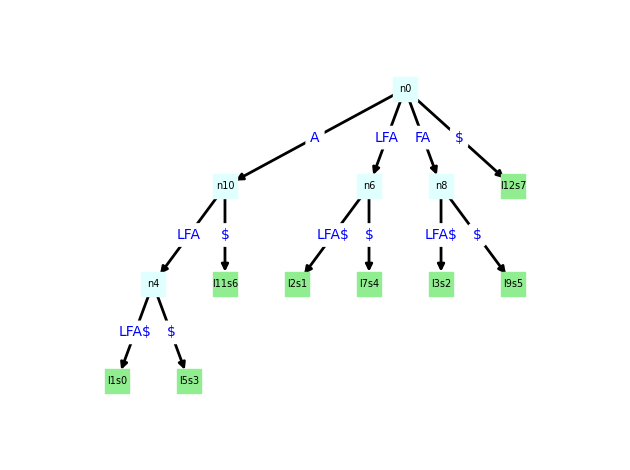

Adding suffix link n8 --> n10
Adding suffix link n6 --> n8
Adding suffix link n10 --> n0
Adding suffix link n4 --> n6


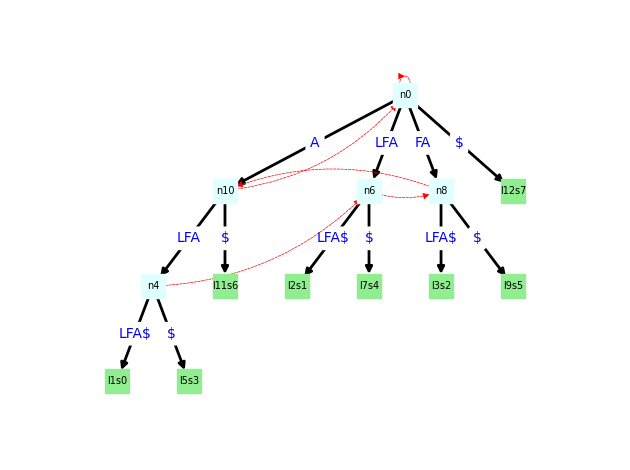

Suffix links are all valid!


In [271]:
def add_all_suffix_links(root, debug=True):
    root.add_suffix_link(root) # root must be suffix linked to itself.
    worklist = [] # a list of edges wherein parent has a suffix link but child does not
    for (_, edge) in root.outgoing_edges.items():
        # iterate through all outgoing edges of the root
        if not edge.is_leaf_edge():
            worklist.append(edge) # add the edge from root to an internal non-leaf node to the worklist.
    ## now iterate through the worklist
    while len(worklist) >= 1:
        edge = worklist.pop()
        assert not edge.is_leaf_edge()
        p = edge.src
        n = edge.dest 
        # this is an edge from parent p to node n
        s_n = get_suffix_link_for_dest_node(edge) # use the edge data to get the suffix node
        n.add_suffix_link(s_n)
        if debug:
            print(f'Adding suffix link n{n.id} --> n{s_n.id}')
        for (_, next_edge) in n.outgoing_edges.items():
            if not next_edge.is_leaf_edge():
                worklist.append(next_edge)
    return 


def findRoot(node):
    x=[]
    x.append(node)
    while (x[-1].parent!=None):
        x.append(x[-1].parent)
    return x[-1]

def recurFindSuf(edge,hi):
    if edge.hi==hi:
        return edge.dest
    else:
        outs=edge.dest.outgoing_edges
        for out in outs:
            return recurFindSuf(out,hi)


def get_suffix_link_for_dest_node(edge):
    p = edge.src
    n = edge.dest
    assert p.suffix_link != None, f"parent {p.id} has no suffix link but asking for the suffix link of a child"
    assert not edge.is_leaf_edge()
    orig_str = edge.orig_str #ALFALFA$
    lo = edge.lo # pos i
    hi = edge.hi # pos f
    assert 0 <= lo <= hi and hi < len(orig_str)
    ## TODO: implement the algorithm to find the suffix link of n 
    ##       given that of p and the data for the edge from p -> n
    
    # your code here
    #raise NotImplementedError
    par=n.parent
    
    if (par.parent==None): #root
        if lo==hi:
            return par
        substr=orig_str[lo+1:hi+1]
        #print(substr)
        es=par.outgoing_edges
        for (_,e) in es.items():
            #print(_,e.lo,e.hi)
            if orig_str[e.lo:e.hi+1]==substr:
                return e.dest
            if not e.is_leaf_edge():
                es2=e.dest.outgoing_edges
                for (_2,e2) in es2.items():
                    if orig_str[e.lo:e2.hi+1]==substr:
                        return e2.dest
                #return recurFindSuf(edge,hi) 
    else:
        substr=orig_str[lo:hi+1]
        root=findRoot(par)
        outs=root.outgoing_edges
        for (_,out) in outs.items():
            if orig_str[out.lo:out.hi+1]==substr:
                return out.dest
            if not out.is_leaf_edge():
                es2=out.dest.outgoing_edges
                for (_2,e2) in es2.items():
                    if orig_str[out.lo:e2.hi+1]==substr:
                        return e2.dest


    return None
    

root = make_suffix_trie_simple("ALFALFA$")
draw_networkx_graph(root)
add_all_suffix_links(root)
draw_networkx_graph(root)

check_suffix_links(root)
    

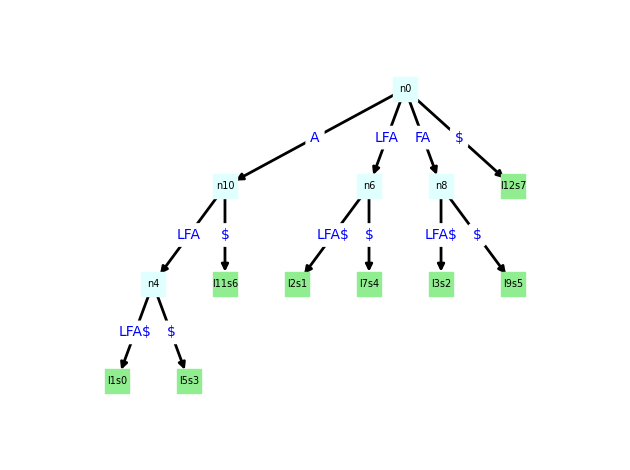

Adding suffix link n8 --> n10
Adding suffix link n6 --> n8
Adding suffix link n10 --> n0
Adding suffix link n4 --> n6


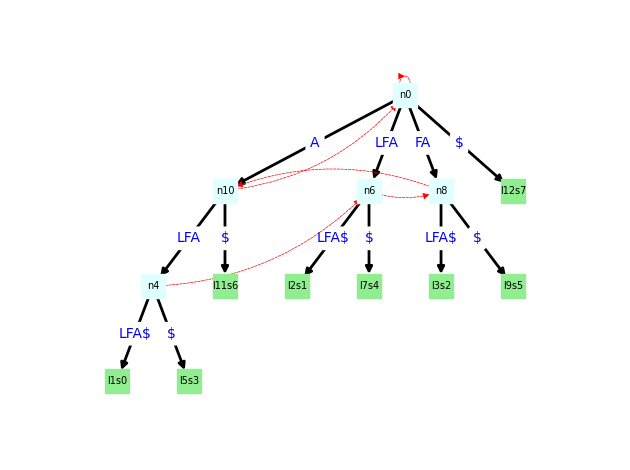

Suffix links are all valid!


In [264]:
root = make_suffix_trie_simple("ALFALFA$")
draw_networkx_graph(root)
add_all_suffix_links(root)
draw_networkx_graph(root)

check_suffix_links(root)

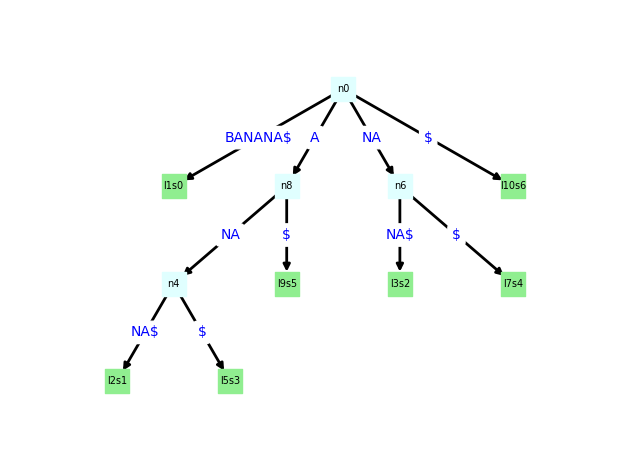

Adding suffix link n6 --> n8
Adding suffix link n8 --> n0
Adding suffix link n4 --> n6


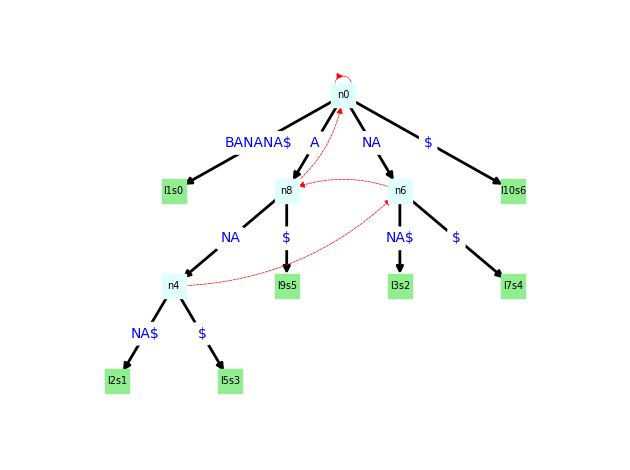

Suffix links are all valid!


In [272]:
root = make_suffix_trie_simple("BANANA$")
draw_networkx_graph(root)
add_all_suffix_links(root)
draw_networkx_graph(root)

check_suffix_links(root)

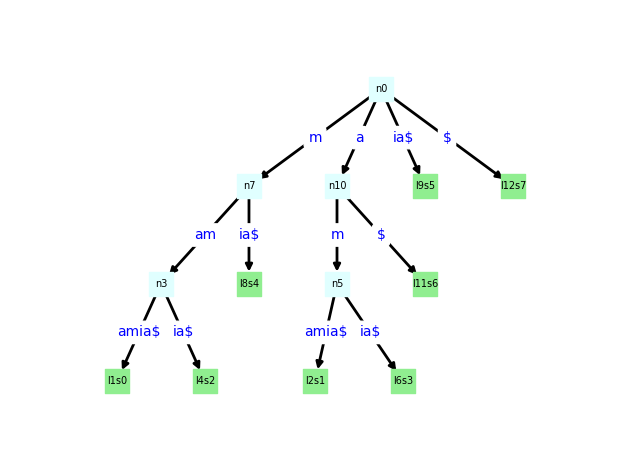

Adding suffix link n10 --> n0
Adding suffix link n5 --> n7
Adding suffix link n7 --> n0
Adding suffix link n3 --> n5


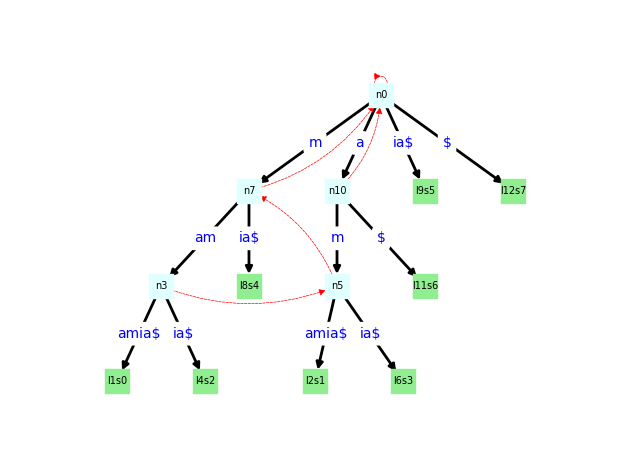

Suffix links are all valid!


In [273]:
root = make_suffix_trie_simple("mamamia$")
draw_networkx_graph(root)
add_all_suffix_links(root)
draw_networkx_graph(root)

check_suffix_links(root)

## Problem 3

Given a string $s$ of length $n$, find the longest palindrome that is a substring of $s$ in time $O(|s|)$. You may use copy over the implementation of Ukkonen's algorithm from the notes compute the suffix trie for $s$ or the method from the previous problem even though it takes $O(|s|^2)$.


In [250]:
def find_longest_palindrome(s):
    # your code here
    #raise NotImplementedError
    n=len(s)
    maxl=0
    fin=0
    ii=-1
    debut=-1
    debuti=-1
    fini=0
    maxli=0
    
    for i in range(n):
        for j in range(i+1,n):
            test=True
            for z in range(j-i):
                #print(s[i:j+1][z],s[i:j+1][-z],s[i:j+1][z]==s[i:j+1][-z])
                test=test and s[i:j+1][z]==s[i:j+1][-z]
            #print(s[i:j+1],'|',s[i:j+1][::-1],'|',s[i:j+1]==s[j:i-1:-1],j-i)
            if s[i:j+1]==s[i:j+1][::-1] and j-i>maxli:
                #print("mise à jour")
                debuti=i
                maxli=j-i
                fini=j
    #print(debuti,fini,s[debuti:fini+1])
    if debuti!=-1:
        return s[debuti:fini+1]
    return None

t = find_longest_palindrome("MALAYALAM$")
#print(t)
assert t == "MALAYALAM"

mise à jour


In [238]:
t = find_longest_palindrome("ABRACADABRA$")
print(t)
assert t == "ADA" or t == "ACA"

ACA


In [251]:
t = find_longest_palindrome("MALAYALAM$")
print(t)
assert t == "MALAYALAM"

mise à jour
MALAYALAM


In [240]:
t = find_longest_palindrome("ABCDCAB$")
print(t)
assert t == "CDC"

CDC


In [241]:
t = find_longest_palindrome("ACAGCGACTTAGGCAGACTGGGGGTCAGCGATTGAGGCA$")
print(t)
assert len(t) == 13 
assert t == "GACTGGGGGTCAG"

GACTGGGGGTCAG


## Answers to select manual problems

### 2(A) 
Since $r$ is the root, the substring would be $s[lo+1]\cdots s[hi]$ if $hi > lo$ or else it would simply be the empty substring.
### 2(B)
The substring in this case would be $s[lo],\ldots, s[hi]$.
### 2(C)
It should be $n0$. Since the parent of n8 is the root, it must be an edge of offset 0 starting from the root, which is the root itself.
### 2(D)
It should be $n6$. We note that the string along $n8 \rightarrow n4$ is "NA". We note that following the string "NA" from the root gives us the target $n6$. Therefore, $\suff(n4) = n6$.

## That's All Folks